In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
df = pd.read_csv("shots_2022.csv")
df = df[(df['shotOnEmptyNet']==0)&(df['shotWasOnGoal']>=0)&(df['isPlayoffGame']==0)]
df = df.loc[:, ["shotID", "xCord", "yCord", "goal", "teamCode", "game_id", "goalieNameForShot", 
                "shooterName", "shotAngle", "shotDistance", "shotType", "time"]]

def get_qualities(df):
    #Map shot quality from 1 to 6 based on distance & if taken from behind the net
    #Rank = 1 if taken from  distance >= farthest in-zone point - 15ft
    #Rank = 2 if shot was taken outside faceoff dots or from behind the net
    #Rank = 3 if shot was taken from >= 27 feet away from net
    #Rank = 4 if shot was taken from >= 30 ft wide slot
    #Rank = 5 if shot was taken from >= 15.6 ft wide slot
    #Rank = 6 if shot was taken >= 10.3 feet away
    #Rank = 7 if shot was taken >= 7 feet away
    #Rank = 8 if shot was taken from >= 6.41 feet away
    #Rank = 9 if shot was taken from < 6.41 feet away
    
    df['quality'] = df.apply(lambda x: 
        1 if ((x['shotDistance'])>=(math.sqrt(64**2 + 42.5**2))-15) else(
        2 if (x['yCord']>=21)|(x['yCord']<=-21)|(x['xCord']<-89)|(x['xCord']>89) else(
        3 if (x['shotDistance']>= 27) else (
        4 if (x['yCord']>=12.5)|(x['yCord']<=-12.5) else (
        5 if (x['yCord']>=7.8)|(x['yCord']<=-7.8) else( 
        6 if (x['shotDistance']>= 10.3) else (
        7 if (x['shotDistance']>= 7) else (
        8 if (x['shotDistance']>= 6.41) else 9))))))), axis=1)
    return df

In [3]:
def create_circle(coords, c):
    return plt.Circle(xy=(coords[0],coords[1]), radius=15, color=c, fill=False)
def plot_rink(df, title):
    sns.set(rc={"figure.figsize":(20, 8.5)})
    rink = sns.scatterplot(x='xCord', y='yCord', data=df, hue='quality', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)
    plt.title(title)
    #Create rink lines
    rink.axvline(0, color='red')
    rink.axvline(-25, color='blue')
    rink.axvline(25, color='blue')
    rink.axvline(89, color='red')
    rink.axvline(-89, color='red')
    rink.add_patch(create_circle([0,0], 'blue'))
    rink.add_patch(create_circle([69,22], 'red'))
    rink.add_patch(create_circle([-69,22], 'red'))
    rink.add_patch(create_circle([69,-22], 'red'))
    rink.add_patch(create_circle([-69,-22], 'red'))
    rink.grid(False)
    plt.xlim(-100,100)
    plt.ylim(-42.5,42.5)

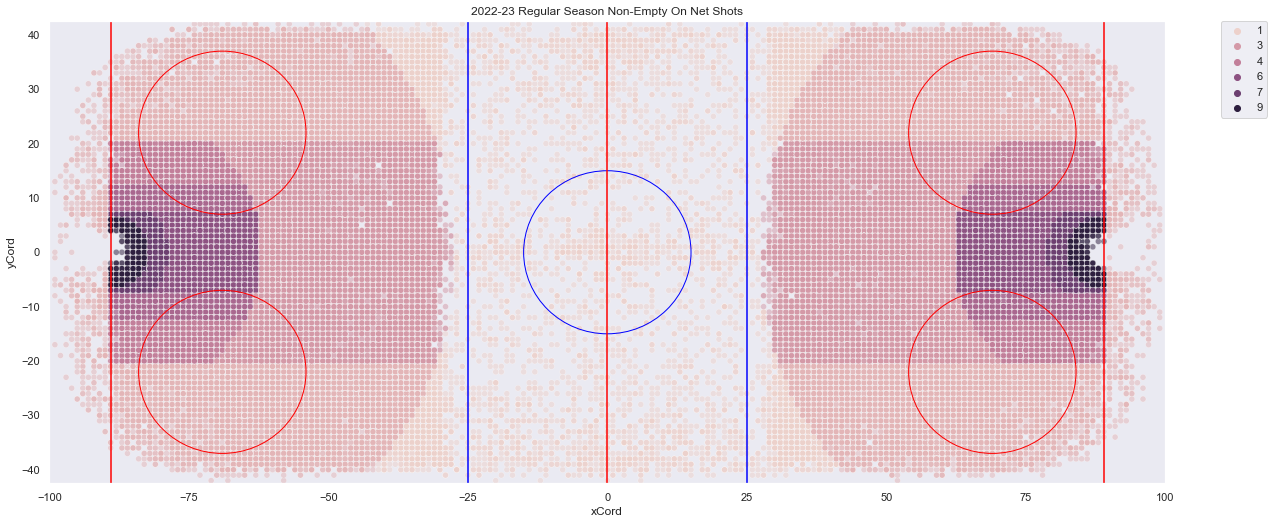

In [4]:
df2 = get_qualities(df)
df_goals=df2[df2['goal']>0]
df_saves=df2[df2['goal']==0]
plot_rink(df_saves, "2022-23 Regular Season Non-Empty On Net Shots")

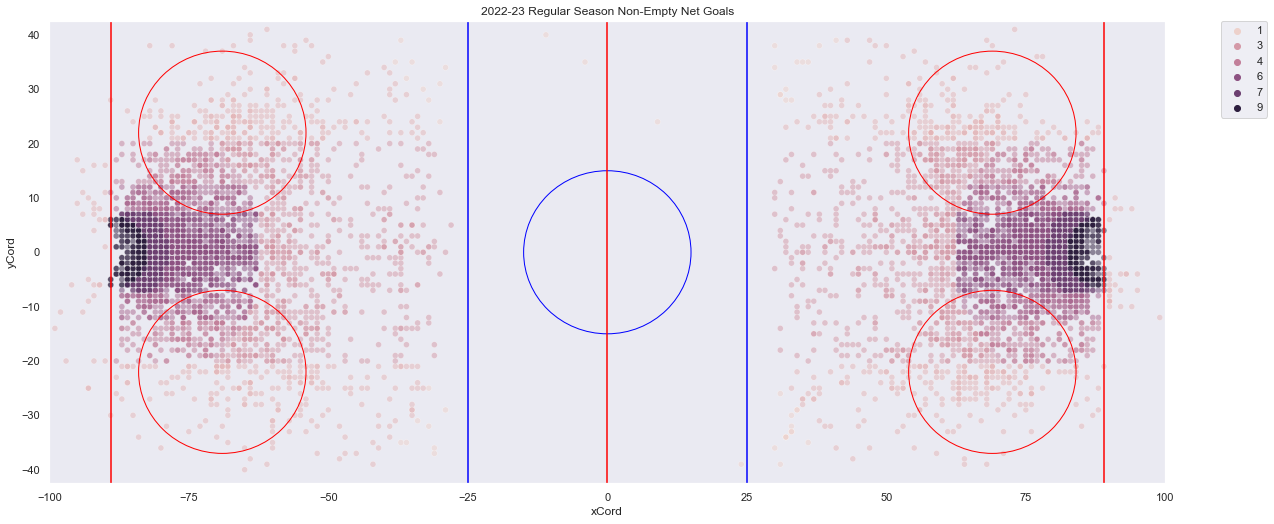

In [5]:
plot_rink(df_goals, "2022-23 Regular Season Non-Empty Net Goals")

In [6]:
#Get percentage of shots that are goals based on the quality
def get_goal_percentage_by_shot_quality(df):
    df['goal_percentage_by_quality'] = ((df.groupby('quality')['goal'].transform('sum') / df.groupby('quality')['goal']
                                         .transform('count')) * 100)
    return df

In [7]:
#Function from https://www.statology.org/seaborn-barplot-show-values/
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

0.9998469296760896


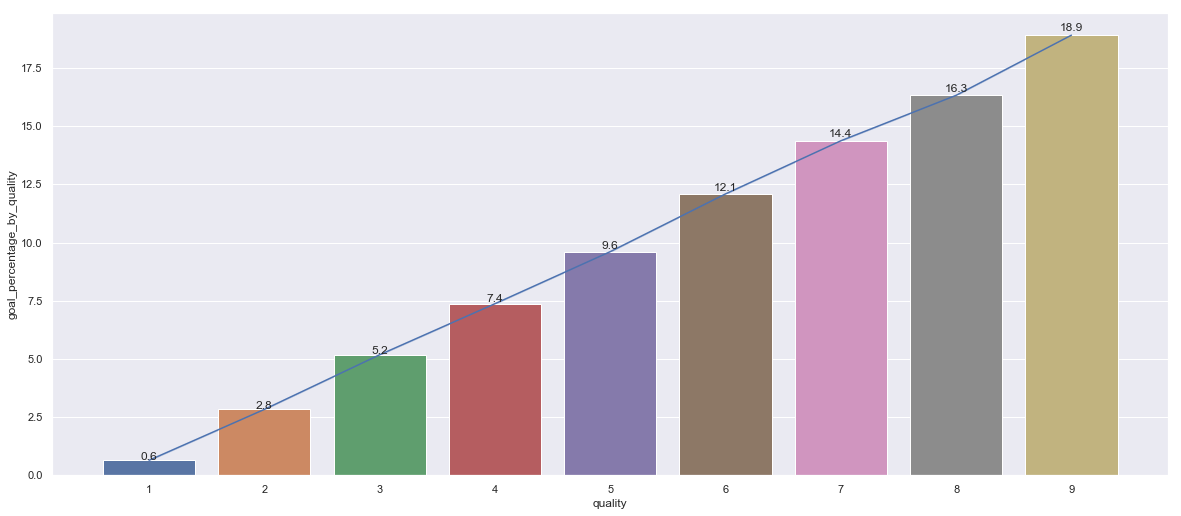

In [8]:
average_quality_save_percentages_df = get_goal_percentage_by_shot_quality(df2)
average_goal_percentage_by_shot_quality = average_quality_save_percentages_df.drop_duplicates('quality').sort_values('quality')
print(average_quality_save_percentages_df.drop_duplicates('quality').corr()['quality']['goal_percentage_by_quality'])

bar_plot = sns.barplot(x='quality', y='goal_percentage_by_quality', data=average_quality_save_percentages_df.drop_duplicates('quality'))
sns.lineplot(x=(average_quality_save_percentages_df['quality']-1), y='goal_percentage_by_quality', 
             data = average_quality_save_percentages_df)

show_values(bar_plot)

In [9]:
def get_goalie_SPAAsq(df, average_df, name, plot, plot_average):
    # Check each goalie's shots in different qualities to see performance
    df = df[df['goalieNameForShot']==name]
    df['goal_percentage_by_quality'] = ((df.groupby('quality')['goal'].transform('sum') / 
                                             df.groupby('quality')['goal'].transform('count')) * 100)
    df_qualities = df.drop_duplicates('quality').sort_values('quality')
    
    if plot:
        sns.lineplot(x=(df['quality']-1), y='goal_percentage_by_quality', data = df, label=name)
        if plot_average:
            sns.lineplot(x=(average_df['quality']-1), y='goal_percentage_by_quality', data = average_df, color='red', 
                         label='Average')
            bar_plot = sns.barplot(x='quality', y='goal_percentage_by_quality', data=df.drop_duplicates('quality'))
            show_values(bar_plot)
    
    average_goal_percentage_by_shot_quality.rename(columns={'goal_percentage_by_quality': 'average_goal_percentage'}, 
                                                   inplace=True)

    # Merge the DataFrames on the 'quality' column
    merged_df = df_qualities.merge(average_goal_percentage_by_shot_quality, on='quality', how='left')

    # Calculate the difference and create a new column 'SPAAsq'
    merged_df['SPAAsq'] = merged_df['average_goal_percentage'] - merged_df['goal_percentage_by_quality']
    return merged_df['SPAAsq']

In [10]:
#Get SPAAsq for all goalies
def get_all_SPAAsq(df, average, plot):
    goalies = df.drop_duplicates('goalieNameForShot').loc[:, ['goalieNameForShot']]
    goalies.rename(columns={'goalieNameForShot':'Name'}, inplace=True)
    new_columns = goalies['Name'].apply(lambda x: get_goalie_SPAAsq(df, average, x, plot, True))
    new_columns.columns = ['SPAA_Quality1', 'SPAA_Quality2', 'SPAA_Quality3', 'SPAA_Quality4', 'SPAA_Quality5', 
                       'SPAA_Quality6', 'SPAA_Quality7', 'SPAA_Quality8', 'SPAA_Quality9']
    goalies = pd.concat([goalies, new_columns], axis=1)
    goalies.reset_index(drop=True, inplace=True)
    goalies.fillna(0, inplace=True)
    return goalies

In [11]:
def get_all_GSAA(goalies, df):
    # Calculate the count of shots for each goalie by each quality level
    shots_count_by_goalie_quality = df.groupby(['goalieNameForShot', 'quality']).size().unstack(fill_value=0)

    # Iterate through the quality columns and create/update the corresponding GSAA columns in the goalies DataFrame
    for quality in range(1, 10):
        spaa_col_name = f'SPAA_Quality{quality}'
        gsaa_col_name = f'GSAA_Quality{quality}'
        if spaa_col_name in goalies.columns:
            goalies[gsaa_col_name] = round(goalies[spaa_col_name] / 100 * goalies['Name'] 
                                      .map(shots_count_by_goalie_quality[quality]), 4)

    goalies.drop(columns=[f'SPAA_Quality{quality}' for quality in range(1, 10)], inplace=True)

    goalies['GSAA'] = round(goalies.iloc[:, 1:10].sum(axis=1),4)
    goalies = goalies.sort_values('GSAA', ascending = False)
    goalies = goalies[goalies['Name'] != 0]
    return goalies

In [12]:
def get_GSAR_by_names(df, averages, name1, name2):
    goalies = get_all_SPAAsq(df, averages, False)
    g1 = goalies[goalies['Name']==name1]
    g2 = goalies[goalies['Name']==name2]
    g1.set_index('Name', inplace=True)
    g2.set_index('Name', inplace=True)
    diffs = pd.DataFrame()
    
    # Perform subtraction for each quality column
    for i in range(1, 10):
        col = f'SPAA_Quality{i}'
        if col in g1.columns and col in g2.columns:
            diff = round(float(g2[col]) - float(g1[col]), 4)
            diffs[f'SPAA_Quality{i}_diff'] = [diff]
            
    #Determine shot qualities amounts given up with Elliot in net vs projected goals with Johansson
    g1_shots = df[df['goalieNameForShot']==name1].loc[:,['shotID','quality']].groupby('quality').count()
    g1_shots.rename(columns={'shotID':'count'},inplace=True)
    
    # Initialize an empty DataFrame with columns
    result_df = pd.DataFrame(columns=['SPAA_Quality1_diff', 'SPAA_Quality2_diff', 'SPAA_Quality3_diff', 'SPAA_Quality4_diff', 'SPAA_Quality5_diff', 'SPAA_Quality6_diff', 'SPAA_Quality7_diff', 'SPAA_Quality8_diff', 'SPAA_Quality9_diff'])

    for i in range(1, 10):  
        col = f'SPAA_Quality{i}_diff'

        if col in diffs.columns:
            diff = float(diffs[col])
            result_df[col] = [diff * float(g1_shots.loc[i, 'count'])]
            
    # Divide each value in result_df by 100
    result_df = result_df / 100
    total_sum = result_df.sum().sum()
    result_df['GSAR_sq'] = total_sum
    result_df.columns = result_df.columns.str.replace('SPAA', 'GSAR')
    result_df.columns = result_df.columns.str.replace('_diff', '')
    return result_df

<ipython-input-9-894ec3896868>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['goal_percentage_by_quality'] = ((df.groupby('quality')['goal'].transform('sum') /


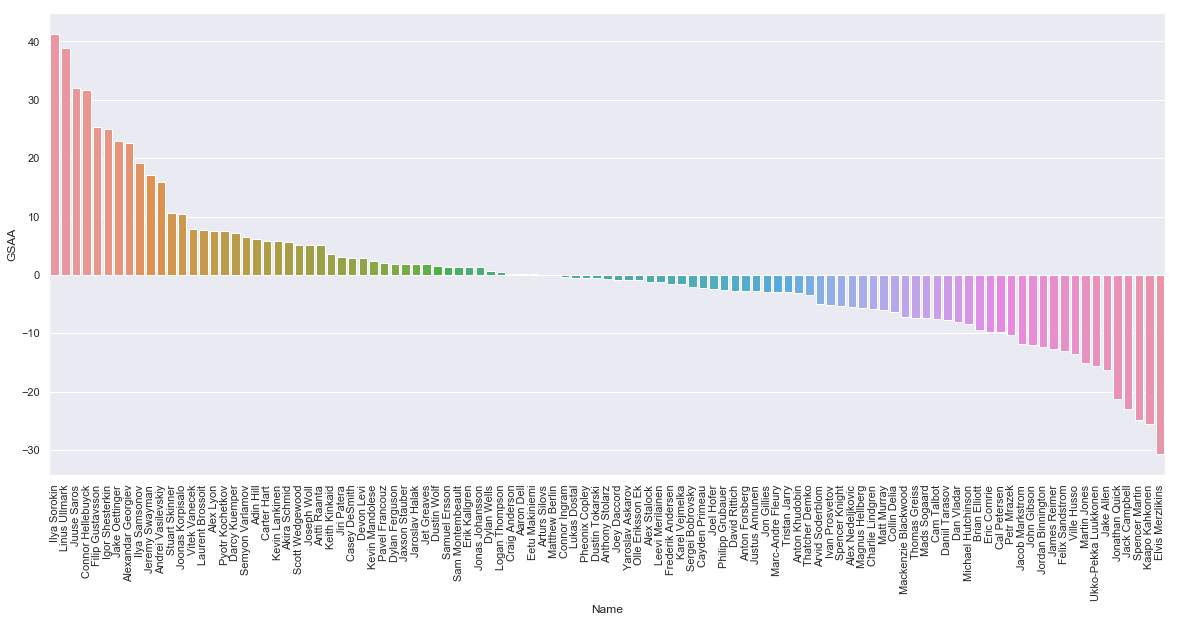

In [13]:
goalies = get_all_GSAA(get_all_SPAAsq(df, average_quality_save_percentages_df, False), df)
plt.xticks(rotation=90)
sns.barplot(data=goalies, x='Name', y='GSAA')
#Create csv with 2022 GSAA data for all goalies
file_path = 'goalies_GSAAsq.csv'
goalies.to_csv(file_path, index=False)

<ipython-input-9-894ec3896868>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['goal_percentage_by_quality'] = ((df.groupby('quality')['goal'].transform('sum') /
<ipython-input-9-894ec3896868>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['goal_percentage_by_quality'] = ((df.groupby('quality')['goal'].transform('sum') /
<ipython-input-9-894ec3896868>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,GSAR_Quality1,GSAR_Quality2,GSAR_Quality3,GSAR_Quality4,GSAR_Quality5,GSAR_Quality6,GSAR_Quality7,GSAR_Quality8,GSAR_Quality9,GSAR_sq
0,-0.388408,3.832211,-0.351288,0.43281,-0.79488,6.601174,6.855357,0.428572,-1.446812,15.168736


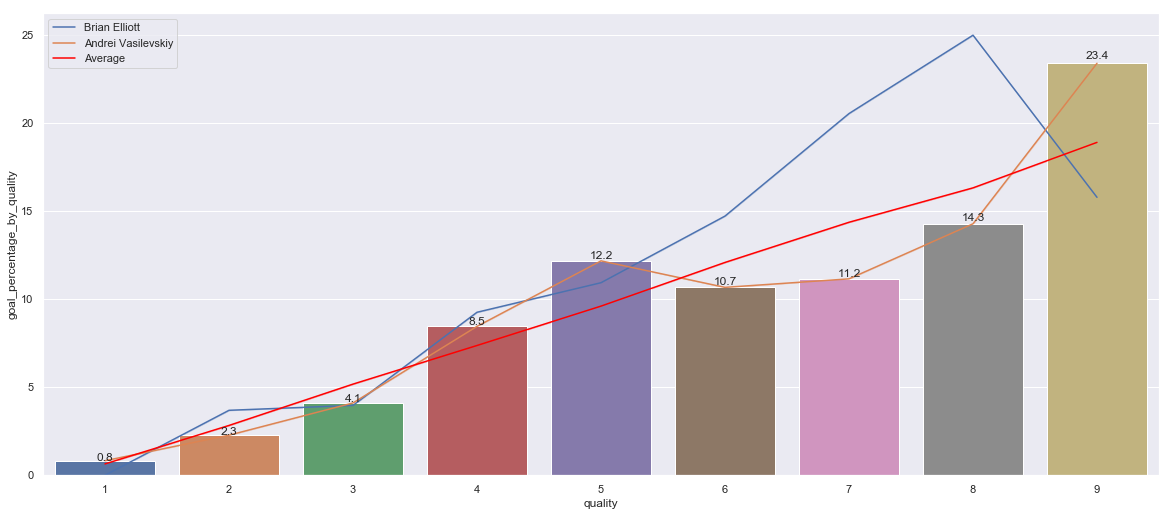

In [14]:
curr_name = 'Brian Elliott'
replacement_name = 'Andrei Vasilevskiy'
get_goalie_SPAAsq(df, average_quality_save_percentages_df, curr_name, True, False)
get_goalie_SPAAsq(df, average_quality_save_percentages_df, replacement_name, True, True)
plt.legend()
get_GSAR_by_names(df, average_quality_save_percentages_df, curr_name, replacement_name)

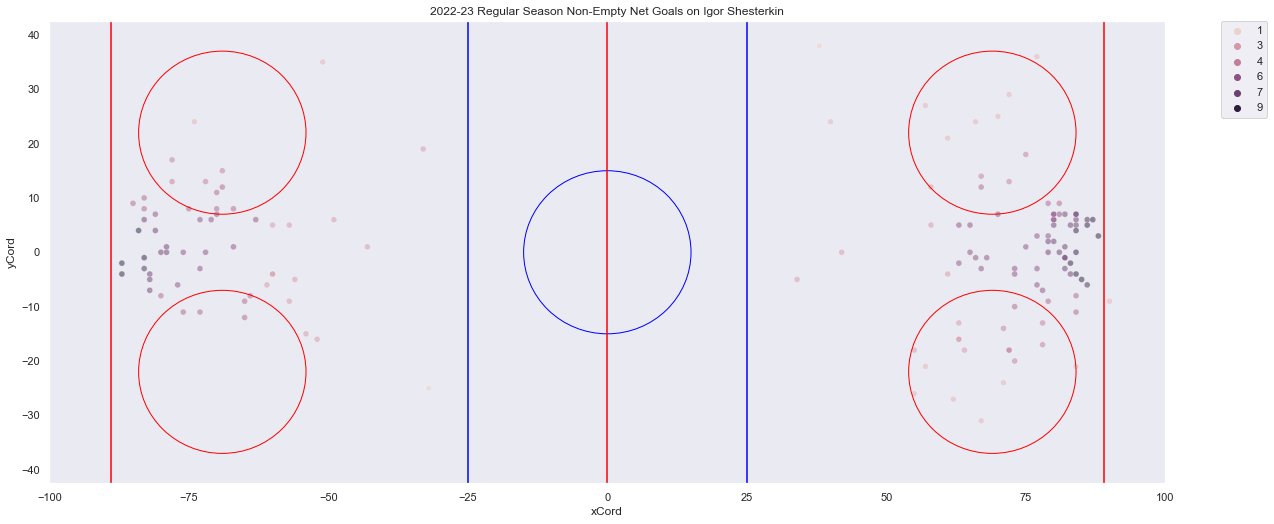

In [15]:
name = "Igor Shesterkin"
plot_rink(df_goals[df_goals['goalieNameForShot']==name], "2022-23 Regular Season Non-Empty Net Goals on "+name)

<ipython-input-9-894ec3896868>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['goal_percentage_by_quality'] = ((df.groupby('quality')['goal'].transform('sum') /


0   -0.848730
1    0.383587
2    1.297697
3    0.529609
4   -1.866749
5    2.610191
6    4.203237
7   -5.102041
8    1.263631
Name: SPAAsq, dtype: float64

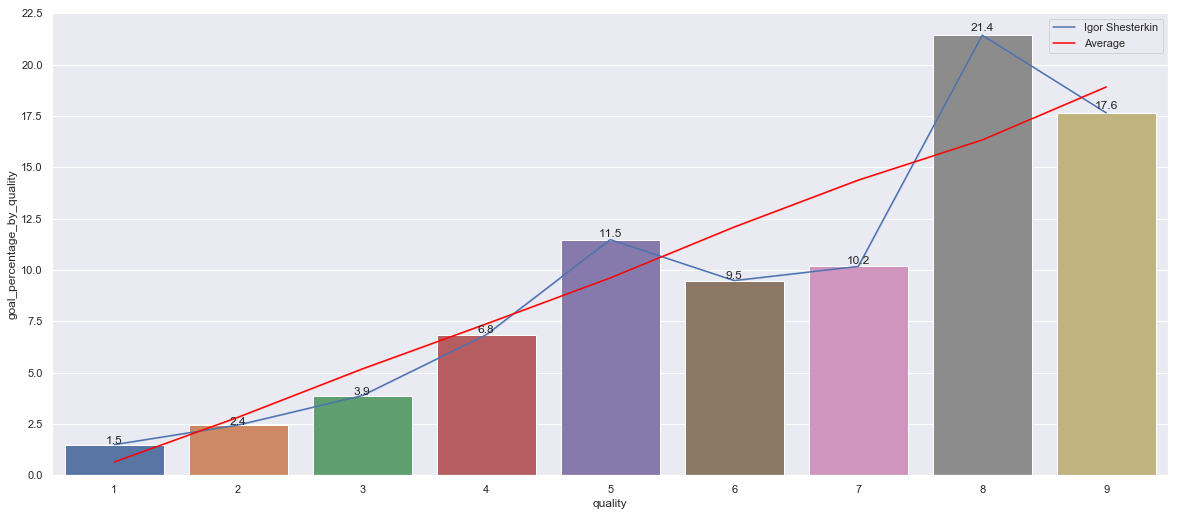

In [16]:
get_goalie_SPAAsq(df, average_quality_save_percentages_df, name, True, True)

<ipython-input-9-894ec3896868>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['goal_percentage_by_quality'] = ((df.groupby('quality')['goal'].transform('sum') /


0    0.643807
1   -0.307184
2    1.493557
3   -4.492692
4    0.680090
5    0.979202
6    4.116318
7    3.826531
8    2.244023
Name: SPAAsq, dtype: float64

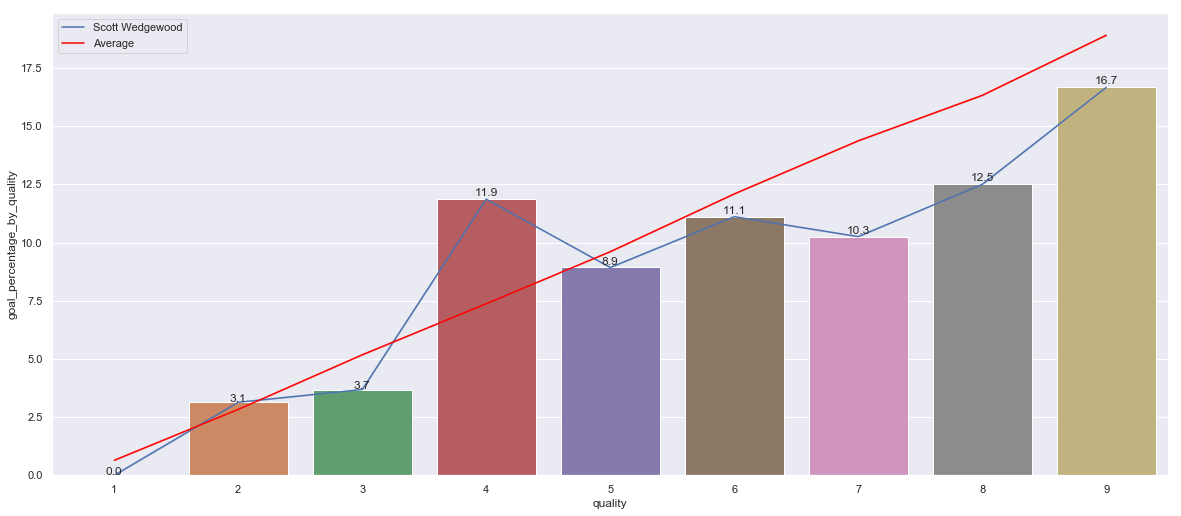

In [17]:
name = "Scott Wedgewood"
get_goalie_SPAAsq(df, average_quality_save_percentages_df, name, True, True)

In [18]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [19]:
url = 'https://www.capfriendly.com/browse/active/2023/caphit/all/goalies?stats-season=2023&limits=gp-1-90'
html = urlopen(url)

In [20]:
soup = BeautifulSoup(html, 'html.parser')
table1 = soup.find('table')
url = 'https://www.capfriendly.com/browse/active/2023/caphit/all/goalies?stats-season=2023&limits=gp-1-90&pg=2'
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')
table2 = soup.find('table')
url = 'https://www.capfriendly.com/browse/active/2023/caphit/all/goalies?stats-season=2023&limits=gp-1-90&pg=3'
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')
table3 = soup.find('table')

In [21]:
# Create empty lists to store the table data and headers
data = []
headers = []

def extract_headers(table):
    # Extract the table headers (th elements) and append them to the 'headers' list
    for th in table.findAll('th'):
        headers.append(th.text.strip())
def extract_table(table):
    # Extract the table rows (tr elements) and their data (td elements)
    for row in table.findAll('tr'):
        row_data = []
        for cell in row.findAll('td'):
            row_data.append(cell.text.strip())
        # Only add rows with data (skip header rows)
        if row_data:
            data.append(row_data)

extract_headers(table1)
extract_table(table1)
extract_table(table2)
extract_table(table3)
        
soupdf = pd.DataFrame(data, columns=headers).loc[:, ['PLAYER', 'TEAM', 'GP', 'CAP HIT']]
soupdf['PLAYER'] = soupdf['PLAYER'].str.replace(r'[0-9.]+', '')
soupdf['CAP HIT'] = soupdf['CAP HIT'].str.replace('[$,]', '', regex=True).astype(float)
soupdf.rename(columns={'PLAYER':'Name', 'TEAM': 'Team', 'CAP HIT': 'Cap'}, inplace=True)
soupdf['Name'] = soupdf['Name'].str.strip()
char_replacements = {
    'ö': 'o',
    'á': 'a',
    'ä': 'a',
    'ø': 'o',
    'é': 'e',
    'Samuel Mo': 'Sam Mo',
    'Daniel': 'Dan'
}
for old_char, new_char in char_replacements.items():
    soupdf['Name'] = soupdf['Name'].str.replace(old_char, new_char)
soupdf['GP'] = pd.to_numeric(soupdf['GP'], errors='coerce')

soupdf.loc[soupdf['Name']=='Craig Anderson', 'Team'] = 'BUF'
soupdf.loc[soupdf['Name']=='Brian Elliott', 'Team'] = 'TBL'
soupdf.loc[soupdf['Name']=='Thomas Greiss', 'Team'] = 'STL'
soupdf.loc[soupdf['Name']=='Jaroslav Halak', 'Team'] = 'NYR'
soupdf.loc[soupdf['Name']=='Keith Kinkaid', 'Team'] = 'NJD'
soupdf.loc[soupdf['Name']=='Olle Eriksson Ek', 'Team'] = 'ANA'
soupdf.loc[soupdf['Name']=='Michael Hutchinson', 'Team'] = 'VGK'
soupdf.loc[soupdf['Name']=='Jon Gillies', 'Team'] = 'ARI'
soupdf.loc[soupdf['Name']=='Martin Jones', 'Team'] = 'SEA'
soupdf.loc[soupdf['Name']=='James Reimer', 'Team'] = 'SJS'
soupdf.loc[soupdf['Name']=='Jonathan Quick', 'Team'] = 'LAK'
soupdf.loc[soupdf['Name']=='Joonas Korpisalo', 'Team'] = 'LAK'
soupdf.loc[soupdf['Name']=='Casey DeSmith', 'Team'] = 'PIT'
soupdf.loc[soupdf['Name']=='Cam Talbot', 'Team'] = 'OTT'
soupdf.loc[soupdf['Name']=='David Rittich', 'Team'] = 'WPG'
soupdf.loc[soupdf['Name']=='Collin Delia', 'Team'] = 'VAN'
soupdf.loc[soupdf['Name']=='Anthony Stolarz', 'Team'] = 'ANA'
soupdf.loc[soupdf['Name']=='Craig Anderson', 'Team'] = 'BUF'
soupdf.loc[soupdf['Name']=='Magnus Hellberg', 'Team'] = 'SEA'
soupdf.loc[soupdf['Name']=='Alex Nedelkjovic', 'Team'] = 'DET'
soupdf.loc[soupdf['Name']=='Laurent Brossoit', 'Team'] = 'VGK'
soupdf.loc[soupdf['Name']=='Erik Kallgren', 'Team'] = 'TOR'
soupdf.loc[soupdf['Name']=='Aaron Dell', 'Team'] = 'SJS'
soupdf.loc[soupdf['Name']=='Jonas Johansson', 'Team'] = 'COL'
soupdf.loc[soupdf['Name']=='Anton Khudobin', 'Team'] = 'DAL'
soupdf.loc[soupdf['Name']=='Dylan Ferguson', 'Team'] = 'OTT'

In [22]:
file_path = 'goalies_salaries.csv'
soupdf.to_csv(file_path, index=False)

In [23]:
goalies_salaries = goalies.merge(soupdf, on=['Name'], how='inner')

#Value Per Million (of Cap hit in 2022-23)
goalies_salaries['VPM'] = (goalies_salaries['GSAA']*0.24) + (goalies_salaries['GP']*0.13) - (goalies_salaries['Cap']/1000000*1.67)
goalies_salaries.sort_values('VPM', inplace=True, ascending = False)
goalies_salaries.reset_index(drop=True, inplace=True)
file_path = 'goalies_VPM.csv'
goalies_salaries.to_csv(file_path, index=False)

In [24]:
result_df = goalies_salaries.groupby('Team').apply(lambda x: x.sort_values('GP', ascending=False).head(2))

In [25]:
import requests

requests.packages.urllib3.disable_warnings()

url = 'https://www.icydata.hockey/team_stats/40'
response = requests.get(url, verify=False)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table')

    if table is not None:
        data = []
        headers = []

        for th in table.findAll('tr')[1]:
            headers.append(th.text.strip())
        extract_table(table)
    else:
        print('No table')
else: 
    print("F")
headers = [item for item in headers if item != '']
soupdf2 = pd.DataFrame(data, columns=headers).loc[:, ['Team', 'Wins']]
soupdf2['Wins'] = pd.to_numeric(soupdf2['Wins'], errors='coerce')
soupdf2.sort_values('Wins', ascending = False, inplace=True)
soupdf2.reset_index(drop=True, inplace=True)

In [26]:
soupdf2.loc[soupdf2['Team']=='Vegas Golden Knights', 'Team'] = 'VGK'
soupdf2.loc[soupdf2['Team']=='Florida Panthers', 'Team'] = 'FLA'
soupdf2.loc[soupdf2['Team']=='Carolina Hurricanes', 'Team'] = 'CAR'
soupdf2.loc[soupdf2['Team']=='Dallas Stars', 'Team'] = 'DAL'
soupdf2.loc[soupdf2['Team']=='Seattle Kraken', 'Team'] = 'SEA'
soupdf2.loc[soupdf2['Team']=='Edmonton Oilers', 'Team'] = 'EDM'
soupdf2.loc[soupdf2['Team']=='New Jersey Devils', 'Team'] = 'NJD'
soupdf2.loc[soupdf2['Team']=='Toronto Maple Leafs', 'Team'] = 'TOR'
soupdf2.loc[soupdf2['Team']=='Boston Bruins', 'Team'] = 'BOS'
soupdf2.loc[soupdf2['Team']=='Colorado Avalanche', 'Team'] = 'COL'
soupdf2.loc[soupdf2['Team']=='New York Rangers', 'Team'] = 'NYR'
soupdf2.loc[soupdf2['Team']=='Los Angeles Kings', 'Team'] = 'LAK'
soupdf2.loc[soupdf2['Team']=='Minnesota Wild', 'Team'] = 'MIN'
soupdf2.loc[soupdf2['Team']=='New York Islanders', 'Team'] = 'NYI'
soupdf2.loc[soupdf2['Team']=='Tampa Bay Lightning', 'Team'] = 'TBL'
soupdf2.loc[soupdf2['Team']=='Winnipeg Jets', 'Team'] = 'WPG'
soupdf2 = soupdf2.rename(columns={'Wins': 'Playoff Wins'})

In [27]:
res_df = (result_df.reset_index(drop=True)).groupby('Team')['GSAA'].sum().reset_index()
playoff_results = result_df.reset_index(drop=True).merge(soupdf2, on='Team', how='inner')
playoff_results.corr()['Playoff Wins']

GSAA_Quality1   -0.229895
GSAA_Quality2   -0.167759
GSAA_Quality3   -0.245312
GSAA_Quality4   -0.142305
GSAA_Quality5   -0.105421
GSAA_Quality6   -0.305181
GSAA_Quality7    0.005700
GSAA_Quality8    0.156560
GSAA_Quality9    0.011819
GSAA            -0.279697
GP              -0.174133
Cap             -0.058364
VPM             -0.195650
Playoff Wins     1.000000
Name: Playoff Wins, dtype: float64

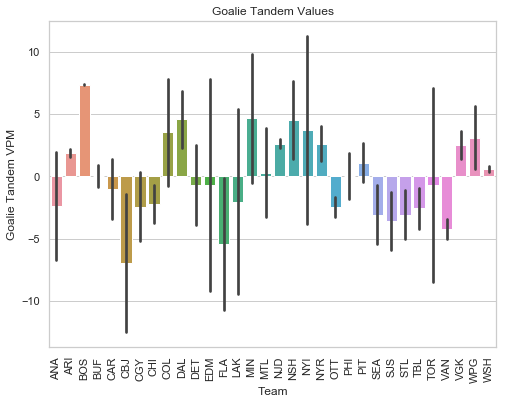

In [28]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(x='Team', y='VPM', data=result_df)

plt.xlabel('Team')
plt.ylabel('Goalie Tandem VPM')
plt.title('Goalie Tandem Values')
plt.xticks(rotation=90)
plt.show()

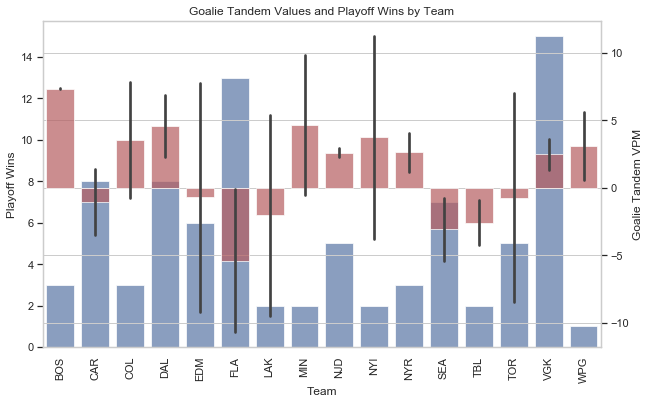

In [38]:
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(x='Team', y='Playoff Wins', data=playoff_results, ax=ax1, color='b', alpha=0.7)
ax1.set_xlabel('Team')
ax1.set_ylabel('Playoff Wins')
ax1.set_title('Goalie Tandem Values and Playoff Wins by Team')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

ax2 = ax1.twinx()
sns.barplot(x='Team', y='VPM', data=playoff_results, ax=ax2, color='r', alpha=0.7)
ax2.set_ylabel('Goalie Tandem VPM')
ax1.yaxis.grid(False)

plt.show()